<a href="https://colab.research.google.com/github/JoseA-Soares/TCC/blob/main/TCC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports ##

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sb
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import resample, shuffle
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, balanced_accuracy_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
import sklearn.tree as SKTree
from sklearn.ensemble import RandomForestClassifier
import sklearn.naive_bayes as SKNB
from sklearn.ensemble import GradientBoostingClassifier


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import keras_tuner as kt

tf.random.set_seed(42)
np.random.seed(42)

### Funções ###

#### Função para armazenar os resultados ####

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pasta_destino = '/content/drive/MyDrive/TCC/Metricas'
pasta_destino1 = '/content/drive/MyDrive/TCC/Metricas/analise'

In [ ]:
def salvar_metricas_tabela(resultado, pasta_destino):
    """Salva as métricas como tabela PNG no Google Drive."""
    nome_arquivo = f"tabela - {resultado['modelo']} - {resultado['iteracao']}.png"
    caminho = os.path.join(pasta_destino, nome_arquivo)

    dados = [
        ["Modelo", resultado['modelo']],
        ["Iteração", resultado['iteracao']],
        ["Accuracy", f"{resultado['accuracy']:.4f}"],
        ["Precision", f"{resultado['precision']:.4f}"],
        ["Recall", f"{resultado['recall']:.4f}"],
        ["F1 Score", f"{resultado['f1_score']:.4f}"],
        ["Balanced Accuracy", f"{resultado['balanced_accuracy']:.4f}"],
        ["ROC AUC", f"{resultado['roc_auc']:.4f}"],
        ["Average Precision", f"{resultado['average_precision']:.4f}"]
    ]

    fig, ax = plt.subplots(figsize=(6, len(dados) * 0.5))
    ax.axis('off')

    tabela = plt.table(
        cellText=dados,
        colLabels=["Métrica", "Valor"],
        loc='center',
        cellLoc='center'
    )

    tabela.auto_set_font_size(False)
    tabela.set_fontsize(10)
    tabela.scale(1, 1.5)

    plt.title(f"Métricas - {resultado['modelo']} (Iter {resultado['iteracao']})", fontsize=12, pad=20)

    plt.savefig(caminho, bbox_inches='tight', dpi=300)
    plt.close()

def salvar_graficos(resultado, pasta_destino):
    """Salva os gráficos separados: ROC, PR e Confusão."""

    modelo = resultado['modelo']
    iteracao = resultado['iteracao']
    fpr, tpr = resultado['roc_curve']
    auc = resultado['roc_auc']
    precisions, recalls = resultado['precision_recall_curve']
    avg_prec = resultado['average_precision']
    conf_mat = resultado['confusion_matrix']

    # --- Curva ROC ---
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    plt.title(f'Curva ROC - {modelo} (Iter {iteracao})')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower right')
    plt.grid(True)
    nome_roc = f"{modelo} - {iteracao} - ROC.png"
    plt.savefig(os.path.join(pasta_destino, nome_roc), bbox_inches='tight', dpi=300)
    plt.close()

    # --- Curva Precision-Recall ---
    plt.figure(figsize=(6, 4))
    plt.plot(recalls, precisions, color='seagreen', lw=2, label=f'AP = {avg_prec:.4f}')
    plt.title(f'Precision-Recall - {modelo} (Iter {iteracao})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(True)
    nome_pr = f"{modelo} - {iteracao} - PR.png"
    plt.savefig(os.path.join(pasta_destino, nome_pr), bbox_inches='tight', dpi=300)
    plt.close()

    # --- Matriz de Confusão ---
    plt.figure(figsize=(6, 5))
    sb.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
               linewidths=0.5, linecolor='gray', annot_kws={"size": 12})
    plt.title(f'Matriz de Confusão - {modelo} (Iter {iteracao})')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    nome_conf = f"{modelo} - {iteracao} - Confusao.png"
    plt.savefig(os.path.join(pasta_destino, nome_conf), bbox_inches='tight', dpi=300)
    plt.close()

In [ ]:
resultados = []

def mostrar_metricas(resultado):
    print(f"Modelo: {resultado['modelo']} (Iteração {resultado['iteracao']})")
    print(f"  Accuracy:  {resultado['accuracy']:.4f}")
    print(f"  Precision: {resultado['precision']:.4f}")
    print(f"  Recall:    {resultado['recall']:.4f}")
    print(f"  F1 Score:  {resultado['f1_score']:.4f}")
    print("-" * 40)

def plotar(resultado):
    sb.set(style='whitegrid')  # define estilo global

    modelo = resultado['modelo']
    iteracao = resultado['iteracao']

    # Recupera os dados das curvas e matriz
    fpr, tpr = resultado['roc_curve']
    auc = resultado['roc_auc']
    precisions, recalls = resultado['precision_recall_curve']
    avg_prec = resultado['average_precision']
    conf_mat = resultado['confusion_matrix']

    # Cria a figura
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    # --- Curva ROC ---
    axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.4f}')
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    axs[0].set_title(f'Curva ROC - {modelo} (Iteração {iteracao})', fontsize=12)
    axs[0].set_xlabel('Taxa de Falsos Positivos (FPR)')
    axs[0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
    axs[0].legend(loc='lower right')
    axs[0].grid(True)

    # --- Curva Precision-Recall ---
    axs[1].plot(recalls, precisions, color='seagreen', lw=2, label=f'AP = {avg_prec:.4f}')
    axs[1].set_title(f'Precision-Recall - {modelo} (Iteração {iteracao})', fontsize=12)
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)

    # --- Matriz de Confusão ---
    sb.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
               ax=axs[2], linewidths=0.5, linecolor='gray', annot_kws={"size": 12})
    axs[2].set_title(f'Matriz de Confusão - {modelo} (Iteração {iteracao})', fontsize=12)
    axs[2].set_xlabel('Predito')
    axs[2].set_ylabel('Verdadeiro')

    plt.tight_layout()
    plt.show()

def metricas(nome_modelo, iteracao, y_true, y_pred, y_proba):
    # Cálculo das métricas principais
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)

    # Precision-Recall
    precisions, recalls, _ = precision_recall_curve(y_true, y_proba)
    avg_prec = average_precision_score(y_true, y_proba)

    # Armazena os resultados em um dicionário
    resultado = {
        'modelo': nome_modelo,
        'iteracao': iteracao,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'balanced_accuracy': bal_acc,
        'roc_auc': auc,
        'average_precision': avg_prec,
        'confusion_matrix': conf_mat,
        'roc_curve': (fpr, tpr),
        'precision_recall_curve': (precisions, recalls)
    }
    mostrar_metricas(resultado)
    plotar(resultado)
    resultados.append(resultado)
    salvar_metricas_tabela(resultado, pasta_destino)
    salvar_graficos(resultado, pasta_destino)

    return

#### Funções para plots das métricas ####

In [ ]:
def plotar_metricas_evolucao(resultados):
    """
    Para cada métrica de interesse em resultados, plota a evolução ao longo das iterações,
    agrupando por modelo. Cada modelo recebe uma cor distinta.
    Métricas: accuracy, precision, recall, f1_score, balanced_accuracy, average_precision.
    """
    sb.set(style='whitegrid')

    # Define quais métricas serão plotadas e seus rótulos
    metricas = {
        'accuracy': 'Accuracy',
        'precision': 'Precision',
        'recall': 'Recall',
        'f1_score': 'F1 Score',
        'balanced_accuracy': 'Balanced Accuracy',
        'average_precision': 'Average Precision'
    }

    # Identifica todos os modelos únicos
    modelos = sorted({r['modelo'] for r in resultados})

    # Gera uma paleta de cores com um tom para cada modelo
    cores = sb.color_palette(n_colors=len(modelos))
    cor_modelo = {modelo: cores[i] for i, modelo in enumerate(modelos)}

    # Para cada métrica, plota um gráfico
    for key, label in metricas.items():
        plt.figure(figsize=(8, 5))
        for modelo in modelos:
            # Seleciona apenas as iterações desse modelo
            sel = [r for r in resultados if r['modelo'] == modelo]
            # Ordena por iteração
            sel = sorted(sel, key=lambda r: r['iteracao'])
            # Pega listas de iterações e valores da métrica
            its  = [r['iteracao'] for r in sel]
            vals = [r[key]       for r in sel]
            # Plota a linha usando a cor dedicada
            plt.plot(its, vals, marker='o', color=cor_modelo[modelo], label=modelo)

        plt.title(f'Evolução de {label} por Iteração')
        plt.xlabel('Iteração')
        plt.ylabel(label)
        plt.xticks(sorted({r['iteracao'] for r in resultados}))
        plt.legend(title='Modelo', loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def plotar_metricas_evolucao(resultados):

    # Configuração visual fixa
    sb.set(style='whitegrid', context='talk', palette='Set2')

    metricas = {
        'accuracy': 'Accuracy',
        'precision': 'Precision',
        'recall': 'Recall',
        'f1_score': 'F1 Score',
        'balanced_accuracy': 'Balanced Accuracy',
        'average_precision': 'Average Precision'
    }

    modelos = sorted({r['modelo'] for r in resultados})
    cores = sb.color_palette('Set2', n_colors=len(modelos))
    cor_modelo = {modelo: cores[i] for i, modelo in enumerate(modelos)}

    # Pasta padrão no Google Drive
    pasta_destino = '/content/drive/MyDrive/TCC/Metricas/analise'
    os.makedirs(pasta_destino, exist_ok=True)

    for key, label in metricas.items():
        plt.figure(figsize=(10, 6))

        for modelo in modelos:
            sel = sorted([r for r in resultados if r['modelo'] == modelo], key=lambda r: r['iteracao'])
            its = [r['iteracao'] for r in sel]
            vals = [r[key] for r in sel]

            plt.plot(its, vals, marker='o', linestyle='-',
                     linewidth=2.5, markersize=8,
                     color=cor_modelo[modelo], label=modelo)

        plt.title(f'Evolução de {label} por Iteração', fontsize=18, weight='bold')
        plt.xlabel('Iteração', fontsize=14)
        plt.ylabel(label, fontsize=14)
        plt.xticks(sorted({r['iteracao'] for r in resultados}))
        plt.legend(title='Modelo', loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Salvar gráfico
        nome_arquivo = os.path.join(pasta_destino, f"Evolucao_{label.replace(' ', '_')}.png")
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')

        plt.show()
        plt.close()

In [ ]:
def plot_roc_por_modelo(resultados):
    """
    Para cada modelo em `resultados`, plota em um subplot a evolução da curva ROC
    ao longo das iterações, com cada iteração numa cor distinta.
    """
    sb.set(style='whitegrid')
    modelos = sorted({r['modelo'] for r in resultados})
    n = len(modelos)
    n_cols = min(3, n)
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for ax, modelo in zip(axes, modelos):
        sel = sorted([r for r in resultados if r['modelo'] == modelo],
                     key=lambda r: r['iteracao'])
        iterations = [r['iteracao'] for r in sel]
        palette = sb.color_palette(n_colors=len(iterations))
        # Mapear cada iteração a uma cor
        cor_it = {it: palette[i] for i, it in enumerate(iterations)}

        for r in sel:
            fpr, tpr = r['roc_curve']
            ax.plot(fpr,
                    tpr,
                    lw=2,
                    color=cor_it[r['iteracao']],
                    label=f"it {r['iteracao']} (AUC={r['roc_auc']:.3f})")
        ax.plot([0,1], [0,1], '--', color='gray')
        ax.set_title(f"ROC — {modelo}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend(fontsize='small')
        ax.grid(True)

    # Remove eixos extras
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_pr_por_modelo(resultados):
    """
    Para cada modelo em `resultados`, plota em um subplot a evolução da curva
    Precision-Recall ao longo das iterações, com cada iteração numa cor distinta.
    """
    sb.set(style='whitegrid')
    modelos = sorted({r['modelo'] for r in resultados})
    n = len(modelos)
    n_cols = min(3, n)
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for ax, modelo in zip(axes, modelos):
        sel = sorted([r for r in resultados if r['modelo'] == modelo],
                     key=lambda r: r['iteracao'])
        iterations = [r['iteracao'] for r in sel]
        palette = sb.color_palette(n_colors=len(iterations))
        cor_it = {it: palette[i] for i, it in enumerate(iterations)}

        for r in sel:
            precisions, recalls = r['precision_recall_curve']
            ax.plot(recalls,
                    precisions,
                    lw=2,
                    color=cor_it[r['iteracao']],
                    label=f"it {r['iteracao']} (AP={r['average_precision']:.3f})")
        ax.set_title(f"PR — {modelo}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(fontsize='small')
        ax.grid(True)

    # Remove eixos extras
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_conf_matrices(resultados, modelo=None):
    """
    Plota as matrizes de confusão armazenadas em `resultados`.
    Se `modelo` for None, plota todos os modelos; caso contrário, apenas as iterações desse modelo.
    """
    # Filtra pelos resultados desejados
    sel = [r for r in resultados if modelo is None or r['modelo'] == modelo]
    if not sel:
        print("Nenhum resultado encontrado para esse modelo.")
        return

    n = len(sel)
    # Define grid: até 4 colunas por linha
    cols = min(4, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for ax, r in zip(axes, sel):
        cm = r['confusion_matrix']
        sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                   ax=ax, linewidths=0.5, linecolor='gray', annot_kws={"size": 12})
        ax.set_title(f"{r['modelo']} iteração {r['iteracao']}")
        ax.set_xlabel('Predito')
        ax.set_ylabel('Verdadeiro')

    # Se sobrar espaço em axes, esconde os eixos extras
    for ax in axes[n:]:
        ax.axis('off')

    plt.suptitle(f"Matrizes de Confusão{' - ' + modelo if modelo else ''}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
def plot_roc_por_modelo_individual(resultados, pasta_destino):
    sb.set(style='whitegrid')
    modelos = sorted({r['modelo'] for r in resultados})

    for modelo in modelos:
        sel = sorted([r for r in resultados if r['modelo'] == modelo],
                     key=lambda r: r['iteracao'])
        iterations = [r['iteracao'] for r in sel]
        palette = sb.color_palette(n_colors=len(iterations))
        cor_it = {it: palette[i] for i, it in enumerate(iterations)}

        plt.figure(figsize=(7, 6))

        for r in sel:
            fpr, tpr = r['roc_curve']
            plt.plot(fpr, tpr, lw=2, color=cor_it[r['iteracao']],
                     label=f"it {r['iteracao']} (AUC={r['roc_auc']:.3f})")

        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.title(f"Curva ROC — {modelo}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(fontsize='small')
        plt.grid(True)
        plt.tight_layout()

        nome_arquivo = os.path.join(pasta_destino, f"ROC - {modelo}.png")
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
        plt.close()

def plot_pr_por_modelo_individual(resultados, pasta_destino):
    sb.set(style='whitegrid')
    modelos = sorted({r['modelo'] for r in resultados})

    for modelo in modelos:
        sel = sorted([r for r in resultados if r['modelo'] == modelo],
                     key=lambda r: r['iteracao'])
        iterations = [r['iteracao'] for r in sel]
        palette = sb.color_palette(n_colors=len(iterations))
        cor_it = {it: palette[i] for i, it in enumerate(iterations)}

        plt.figure(figsize=(7, 6))

        for r in sel:
            precisions, recalls = r['precision_recall_curve']
            plt.plot(recalls, precisions, lw=2, color=cor_it[r['iteracao']],
                     label=f"it {r['iteracao']} (AP={r['average_precision']:.3f})")

        plt.title(f"Curva Precision-Recall — {modelo}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(fontsize='small')
        plt.grid(True)
        plt.tight_layout()

        nome_arquivo = os.path.join(pasta_destino, f"PR - {modelo}.png")
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
        plt.close()

def plot_conf_matrices_individual(resultados, pasta_destino):
    modelos = sorted({r['modelo'] for r in resultados})

    for modelo in modelos:
        sel = [r for r in resultados if r['modelo'] == modelo]
        n = len(sel)
        cols = min(4, n)
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
        axes = axes.flatten()

        for ax, r in zip(axes, sel):
            cm = r['confusion_matrix']
            sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                       ax=ax, linewidths=0.5, linecolor='gray', annot_kws={"size": 12})
            ax.set_title(f"iteração {r['iteracao']}")
            ax.set_xlabel('Predito')
            ax.set_ylabel('Verdadeiro')

        for ax in axes[n:]:
            ax.axis('off')

        plt.suptitle(f"Matrizes de Confusão — {modelo}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        nome_arquivo = os.path.join(pasta_destino, f"Confusao - {modelo}.png")
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
        plt.close()

#### Funções para plots regressão ####

In [ ]:
def plot_loss(history, title='Gráfico de Loss'):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Erro')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_acc(history, title='Gráfico de Acurácia'):
    plt.plot(history.history['accuracy'], label='Acurácia')
    plt.plot(history.history['val_accuracy'], label='Val Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_auc(history, title='Gráfico de AUC'):
    plt.plot(history.history['auc'], label='AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_precision(history, title='Gráfico de Precision'):
    plt.plot(history.history['precision'], label='Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.xlabel('Épocas')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_recall(history, title='Gráfico de Recall'):
    plt.plot(history.history['recall'], label='Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## Leitura e tratamento do dataset ##

In [ ]:
ds = pd.read_csv("/content/drive/MyDrive/TCC/stroke_data.csv")

In [ ]:
print('Quantidade de linha e colunas:')
display(ds.shape)
print('\nPrimeiras 5 linhas')
display(ds.head())

Quantidade de linha e colunas:


(40910, 11)


Primeiras 5 linhas


,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


In [ ]:
print('Descrição dos dados:')
display(ds.describe(include='all'))
print('\n%de nulos no dataset')
display(ds.isna().sum() / ds.shape[0])

Descrição dos dados:


,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,40907.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000
mean,0.555162,51.327255,0.213835,0.127719,0.821340,3.461134,0.514886,122.075901,30.406355,0.488609,0.500122
std,0.496954,21.623969,0.410017,0.333781,0.383072,0.780919,0.499784,57.561531,6.835072,0.499876,0.500006
min,0.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.500000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,0.000000,1.000000,3.000000,0.000000,78.750000,25.900000,0.000000,0.000000
50%,1.000000,52.000000,0.000000,0.000000,1.000000,4.000000,1.000000,97.920000,29.400000,0.000000,1.000000
75%,1.000000,68.000000,0.000000,0.000000,1.000000,4.000000,1.000000,167.590000,34.100000,1.000000,1.000000
max,1.000000,103.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,92.000000,1.000000,1.000000



%de nulos no dataset


,0
sex,0.000073
age,0.000000
hypertension,0.000000
heart_disease,0.000000
ever_married,0.000000
work_type,0.000000
Residence_type,0.000000
avg_glucose_level,0.000000
bmi,0.000000
smoking_status,0.000000


In [ ]:
sex = ds['sex']
display(sex.describe())

,sex
count,40907.000000
mean,0.555162
std,0.496954
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
ds['sex'] = ds['sex'].fillna(0)

In [ ]:
ds['sex'] = ds.sex.map({1: 'Male', 0: 'Female'})
ds['smoking_status'] = ds.smoking_status.map({1: 'Smokes', 0: 'Never_smoked'})
ds['Residence_type'] = ds.Residence_type.map({1: 'Urban', 0: 'Rural'})
ds['work_type'] = ds.work_type.map({0: 'never_worked', 1: 'children', 2: 'Govt_job', 3: 'self_employed', 4: 'private'})

In [ ]:
ds.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,63.0,0,1,1,private,Urban,228.69,36.6,Smokes,1
1,Male,42.0,0,1,1,private,Rural,105.92,32.5,Never_smoked,1
2,Female,61.0,0,0,1,private,Urban,171.23,34.4,Smokes,1
3,Male,41.0,1,0,1,self_employed,Rural,174.12,24.0,Never_smoked,1
4,Male,85.0,0,0,1,private,Urban,186.21,29.0,Smokes,1


In [ ]:
encoder = OneHotEncoder(sparse_output=False)

encoded = encoder.fit_transform(ds[['sex', 'work_type', 'Residence_type', 'smoking_status']])
encoded_ds = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['sex', 'work_type', 'Residence_type', 'smoking_status']))

ds_final = pd.concat([ds, encoded_ds], axis = 1)

In [ ]:
display(ds_final.head())
print('\n% de nulos no dataset')
display(ds.isna().sum() / ds.shape[0])

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,sex_Male,work_type_Govt_job,work_type_children,work_type_never_worked,work_type_private,work_type_self_employed,Residence_type_Rural,Residence_type_Urban,smoking_status_Never_smoked,smoking_status_Smokes
0,Male,63.0,0,1,1,private,Urban,228.69,36.6,Smokes,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,Male,42.0,0,1,1,private,Rural,105.92,32.5,Never_smoked,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Female,61.0,0,0,1,private,Urban,171.23,34.4,Smokes,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,Male,41.0,1,0,1,self_employed,Rural,174.12,24.0,Never_smoked,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,Male,85.0,0,0,1,private,Urban,186.21,29.0,Smokes,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0



% de nulos no dataset


,0
sex,0.0
age,0.0
hypertension,0.0
heart_disease,0.0
ever_married,0.0
work_type,0.0
Residence_type,0.0
avg_glucose_level,0.0
bmi,0.0
smoking_status,0.0


In [ ]:
linhas_negativas = ds_final[(ds_final.select_dtypes(include='number') < 0).any(axis=1)]
linhas_negativas

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,sex_Male,work_type_Govt_job,work_type_children,work_type_never_worked,work_type_private,work_type_self_employed,Residence_type_Rural,Residence_type_Urban,smoking_status_Never_smoked,smoking_status_Smokes
9149,Male,-2.0,1,1,1,private,Rural,271.74,31.1,Smokes,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9277,Male,-5.0,0,0,1,private,Rural,97.92,26.9,Smokes,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9323,Male,-4.0,1,1,0,private,Rural,84.03,26.5,Smokes,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9487,Male,-3.0,0,0,1,private,Rural,224.10,56.6,Never_smoked,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
9505,Male,-1.0,1,0,0,private,Urban,203.87,45.7,Never_smoked,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
9708,Male,-5.0,1,0,1,private,Rural,179.12,28.1,Smokes,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
9808,Male,-3.0,0,1,1,self_employed,Urban,252.72,30.5,Smokes,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
9936,Male,-1.0,1,0,1,private,Rural,58.09,39.2,Smokes,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
10175,Male,-2.0,1,0,1,self_employed,Rural,72.67,28.9,Never_smoked,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
10278,Male,-1.0,1,0,1,private,Rural,243.58,33.6,Never_smoked,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
ds_final['age'] = ds_final['age'].mask(ds_final['age'] < 0, np.nan)

In [ ]:
age = ds_final['age']
display(age.describe())

,age
count,40852.000000
mean,51.404019
std,21.542970
min,0.000000
25%,35.000000
50%,52.000000
75%,68.000000
max,103.000000


In [ ]:
ds_final['age'] = ds_final['age'].fillna(52)

## Análise dos dados ##

<ipython-input-25-0275270d864d>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([colunas[col] for col in colunas.columns], labels=colunas.columns)


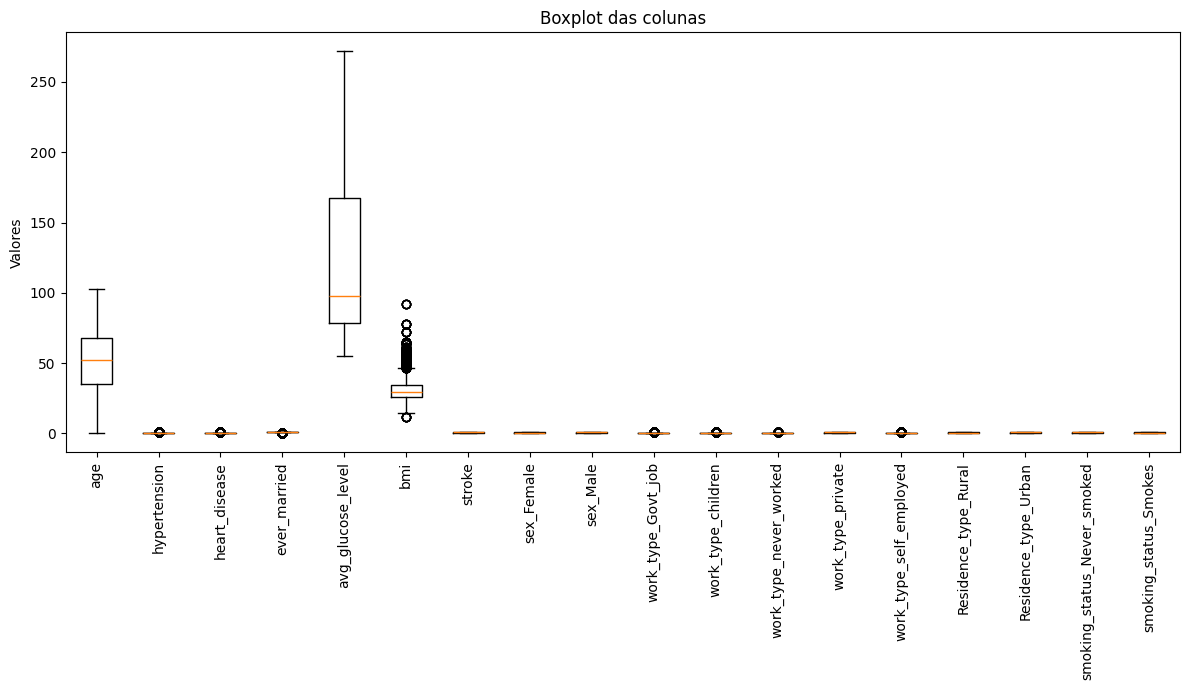

In [ ]:
colunas = ds_final.select_dtypes(include='number')
plt.figure(figsize=(12, 7))
plt.boxplot([colunas[col] for col in colunas.columns], labels=colunas.columns)

plt.title('Boxplot das colunas')
plt.ylabel('Valores')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

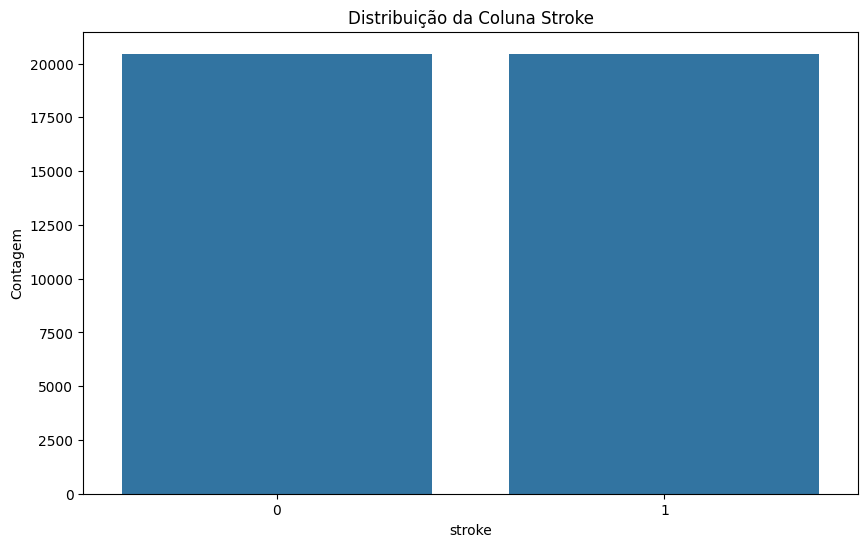

In [ ]:
plt.figure(figsize=(10, 6))
sb.countplot(x='stroke', data=ds_final)
plt.title('Distribuição da Coluna Stroke')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['0', '1'])
plt.show()

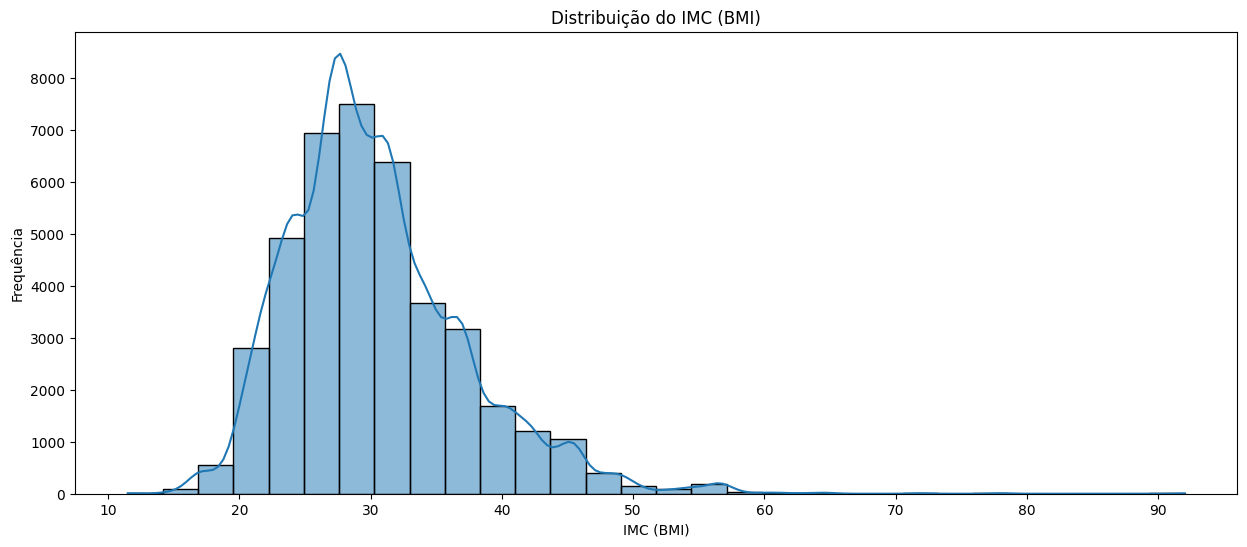

In [ ]:
plt.figure(figsize=(15, 6))
sb.histplot(data=ds_final, x='bmi', bins=30, kde=True)
plt.title('Distribuição do IMC (BMI)')
plt.xlabel('IMC (BMI)')
plt.ylabel('Frequência')
plt.show()

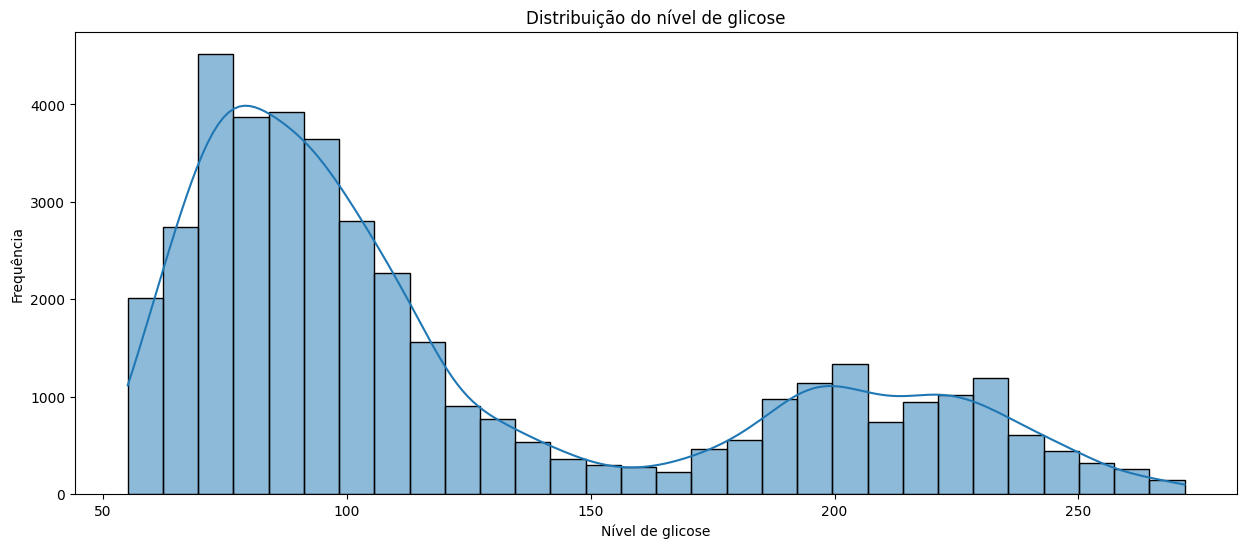

In [ ]:
plt.figure(figsize=(15, 6))
sb.histplot(data=ds_final, x='avg_glucose_level', bins=30, kde=True)
plt.title('Distribuição do nível de glicose')
plt.xlabel('Nível de glicose')
plt.ylabel('Frequência')
plt.show()

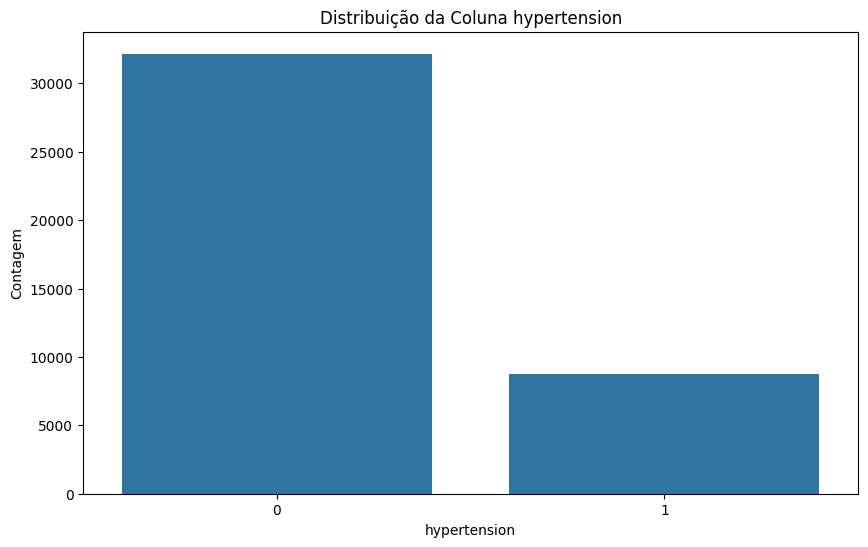

In [ ]:
plt.figure(figsize=(10, 6))
sb.countplot(x='hypertension', data=ds_final)
plt.title('Distribuição da Coluna hypertension')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['0', '1'])
plt.show()

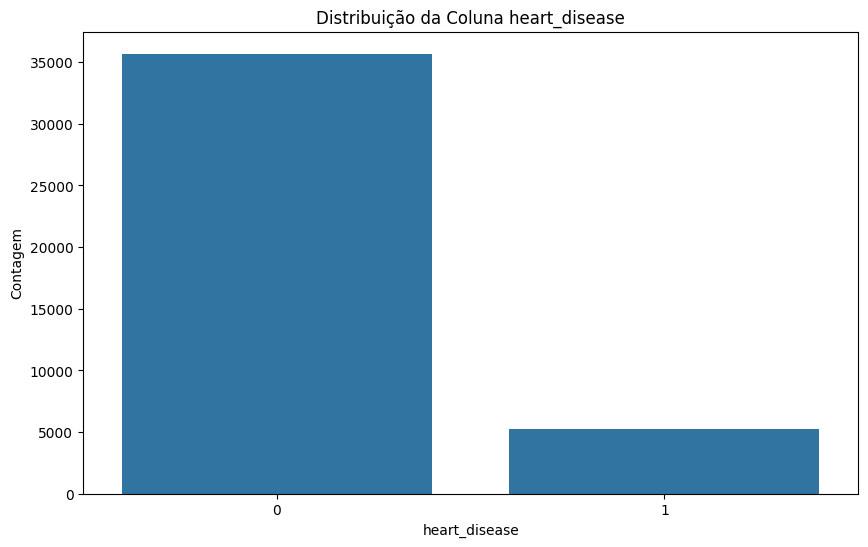

In [ ]:
plt.figure(figsize=(10, 6))
sb.countplot(x='heart_disease', data=ds_final)
plt.title('Distribuição da Coluna heart_disease')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['0', '1'])
plt.show()

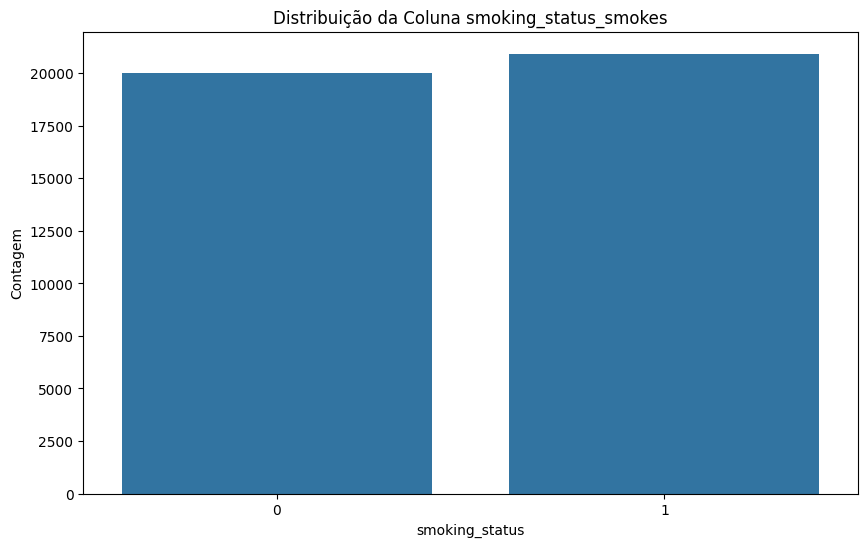

In [ ]:
plt.figure(figsize=(10, 6))
sb.countplot(x='smoking_status', data=ds_final)
plt.title('Distribuição da Coluna smoking_status_smokes')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['0', '1'])
plt.show()

In [ ]:
ds_final = ds_final.drop(['sex', 'work_type', 'Residence_type', 'smoking_status'], axis = 1)

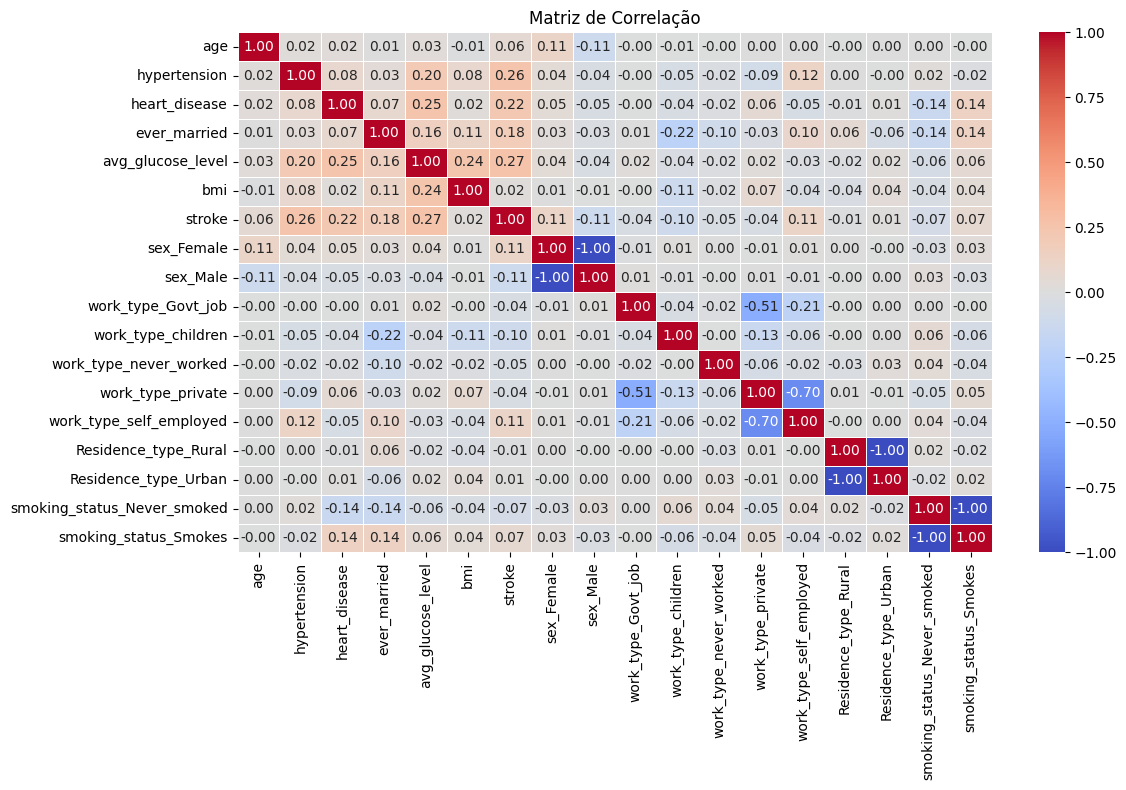

In [ ]:
corr = ds_final.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sb.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

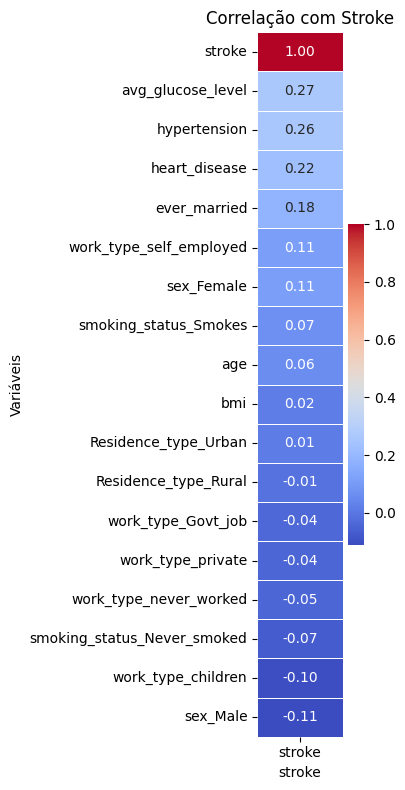

In [ ]:
corr_stroke = corr[['stroke']].sort_values(by='stroke', ascending=False)

# Cria o heatmap com stroke no eixo X
plt.figure(figsize=(4, 8))  # Estreito e alto para 1 coluna
sb.heatmap(corr_stroke, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlação com Stroke')
plt.xlabel('stroke')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

## Treinamento dos modelos ##

### Primeira iteração ####

#### Preparação dos dados ####

In [ ]:
ds =  ds_final.copy()

continuas = [col for col in ds.columns if ds[col].nunique() > 2]

scaler = StandardScaler()
ds[continuas] = scaler.fit_transform(ds[continuas])

ds1 = ds[['age', 'heart_disease', 'avg_glucose_level', 'hypertension', 'sex_Female', 'sex_Male', 'smoking_status_Smokes', 'smoking_status_Never_smoked', 'ever_married', 'stroke']]
ds1 = shuffle(ds1, random_state = 42)

sel = ds1.columns.to_list()
sel.remove('stroke')

X = ds1[sel]
Y = ds1['stroke']

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size=0.3, random_state=42)

#### KNN ####

In [ ]:
knn = KNeighborsClassifier()

# Grid de hiperparâmetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],  # Mantemos minkowski e variamos p
    'p': [1, 2],               # p=1 (manhattan), p=2 (euclidean)
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# GridSearchCV
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # ou 'roc_auc', 'recall'
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Resultados
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Melhores parâmetros encontrados:
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

Relatório de classificação no conjunto de teste:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      6110
           1       0.73      0.76      0.74      6163

    accuracy                           0.74     12273
   macro avg       0.74      0.74      0.74     12273
weighted avg       0.74      0.74      0.74     12273



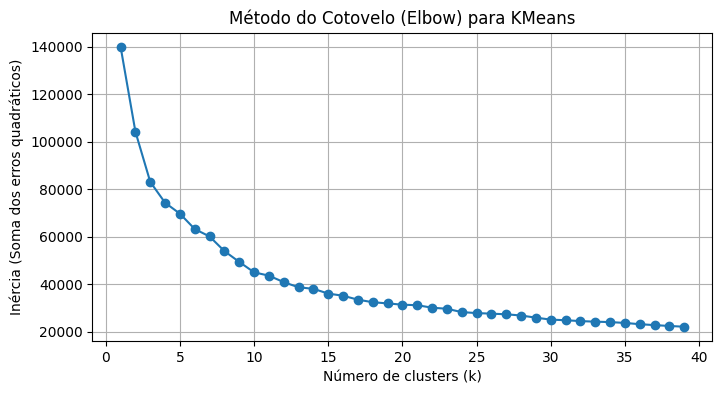

In [ ]:
inertia = []
k_range = range(1, 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# 4. Plotar o gráfico do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow) para KMeans')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma dos erros quadráticos)')
plt.grid(True)
plt.show()

Modelo: KNN (Iteração 1)
  Accuracy:  0.7365
  Precision: 0.7258
  Recall:    0.7638
  F1 Score:  0.7443
----------------------------------------


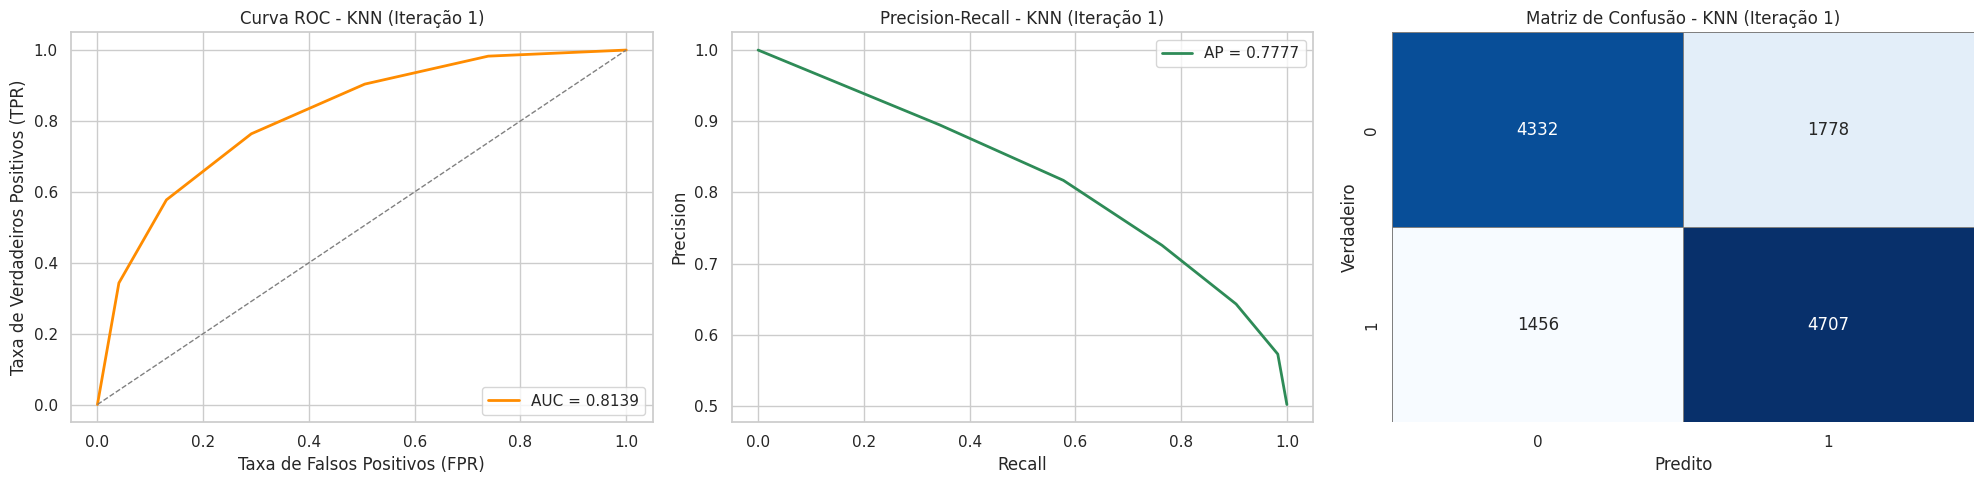

In [ ]:
knn = KNeighborsClassifier(algorithm='ball_tree', metric= 'minkowski', p=1, weights='uniform', n_neighbors=5)
knn.fit(x_treino, y_treino)
y_pred = knn.predict(x_teste)
y_proba = knn.predict_proba(x_teste)[:, 1]
metricas('KNN', 1, y_teste, y_pred, y_proba)

#### Árvore ####

In [ ]:
tree = SKTree.DecisionTreeClassifier(random_state=42, max_depth=None)

# Grid de hiperparâmetros
param_grid = {
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

# Grid search com validação cruzada
grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # ou 'roc_auc', se quiser avaliar melhor o desbalanceamento
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Avaliação
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Melhores parâmetros encontrados:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}

Relatório de classificação no conjunto de teste:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6110
           1       0.99      1.00      0.99      6163

    accuracy                           0.99     12273
   macro avg       0.99      0.99      0.99     12273
weighted avg       0.99      0.99      0.99     12273



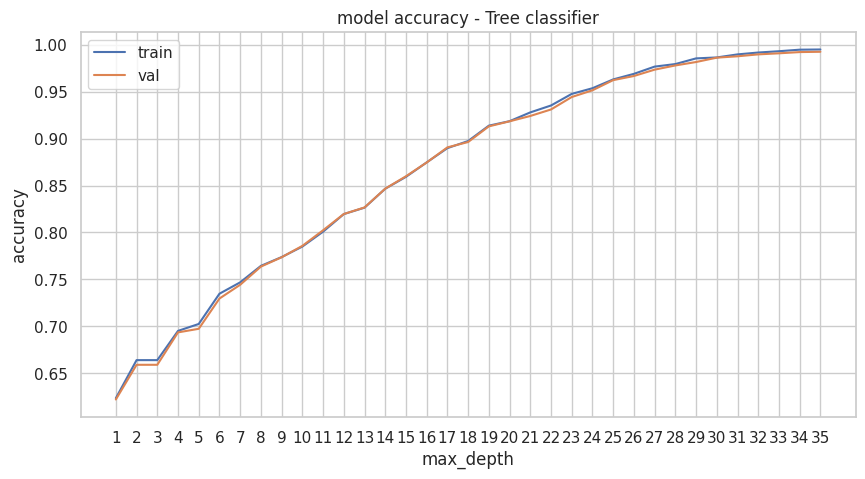

In [ ]:
history_acc_train = []
history_acc_test = []

for max_depth in range(1,36):
  clf = SKTree.DecisionTreeClassifier(class_weight= 'balanced', criterion='entropy', max_depth=max_depth, max_features=None, min_samples_leaf= 2, min_samples_split= 20, random_state=42)
  clf = clf.fit(x_treino, y_treino)
  history_acc_train.append(accuracy_score(y_treino,  clf.predict(x_treino)))
  history_acc_test.append(accuracy_score(y_teste,  clf.predict(x_teste)))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 36),history_acc_train)
plt.plot(range(1, 36),history_acc_test)
plt.xticks(range(1, 36))
plt.title('model accuracy - Tree classifier')
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Modelo: Árvore (Iteração 1)
  Accuracy:  0.9864
  Precision: 0.9754
  Recall:    0.9981
  F1 Score:  0.9866
----------------------------------------


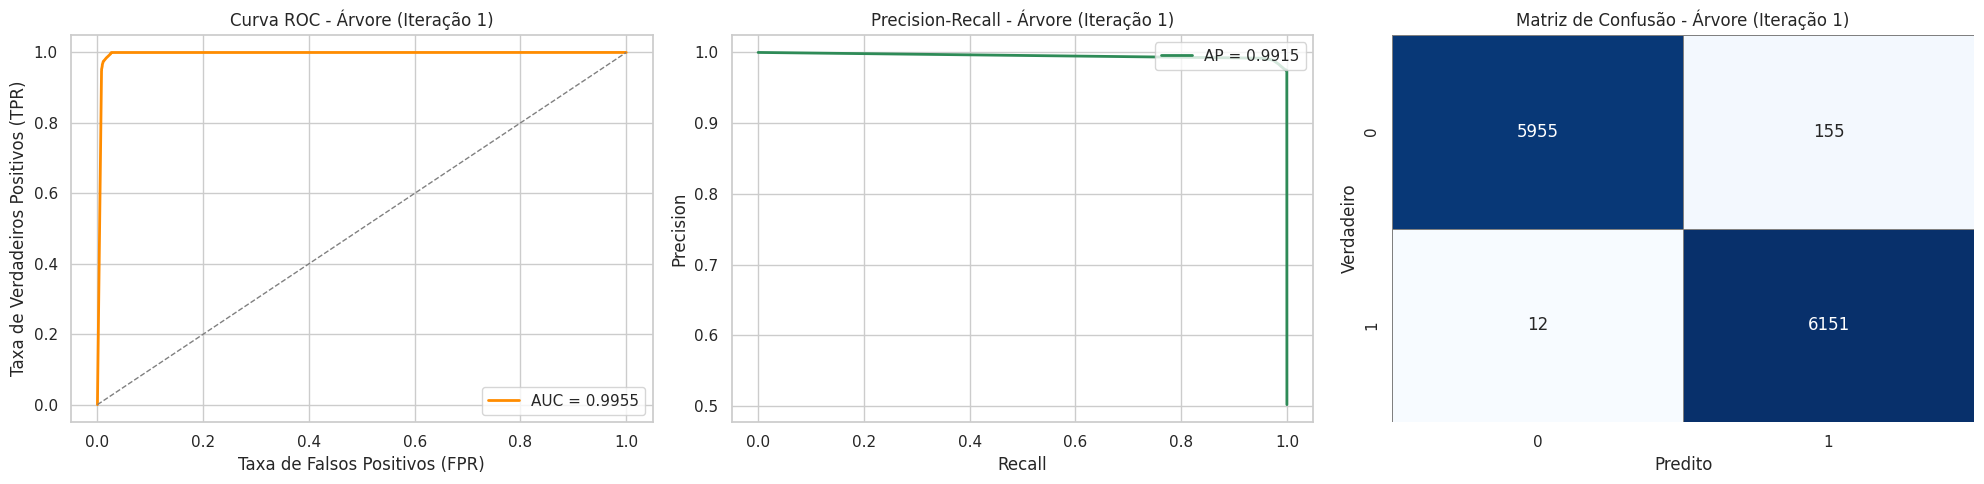

In [ ]:
tree = SKTree.DecisionTreeClassifier(class_weight= 'balanced', criterion='entropy', max_depth=30, max_features=None, min_samples_leaf= 2, min_samples_split= 20, random_state=42)
tree.fit(x_treino, y_treino)
y_pred = tree.predict(x_teste)
y_proba = tree.predict_proba(x_teste)[:, 1]
metricas('Árvore', 1, y_teste, y_pred, y_proba)

<function matplotlib.pyplot.show(close=None, block=None)>

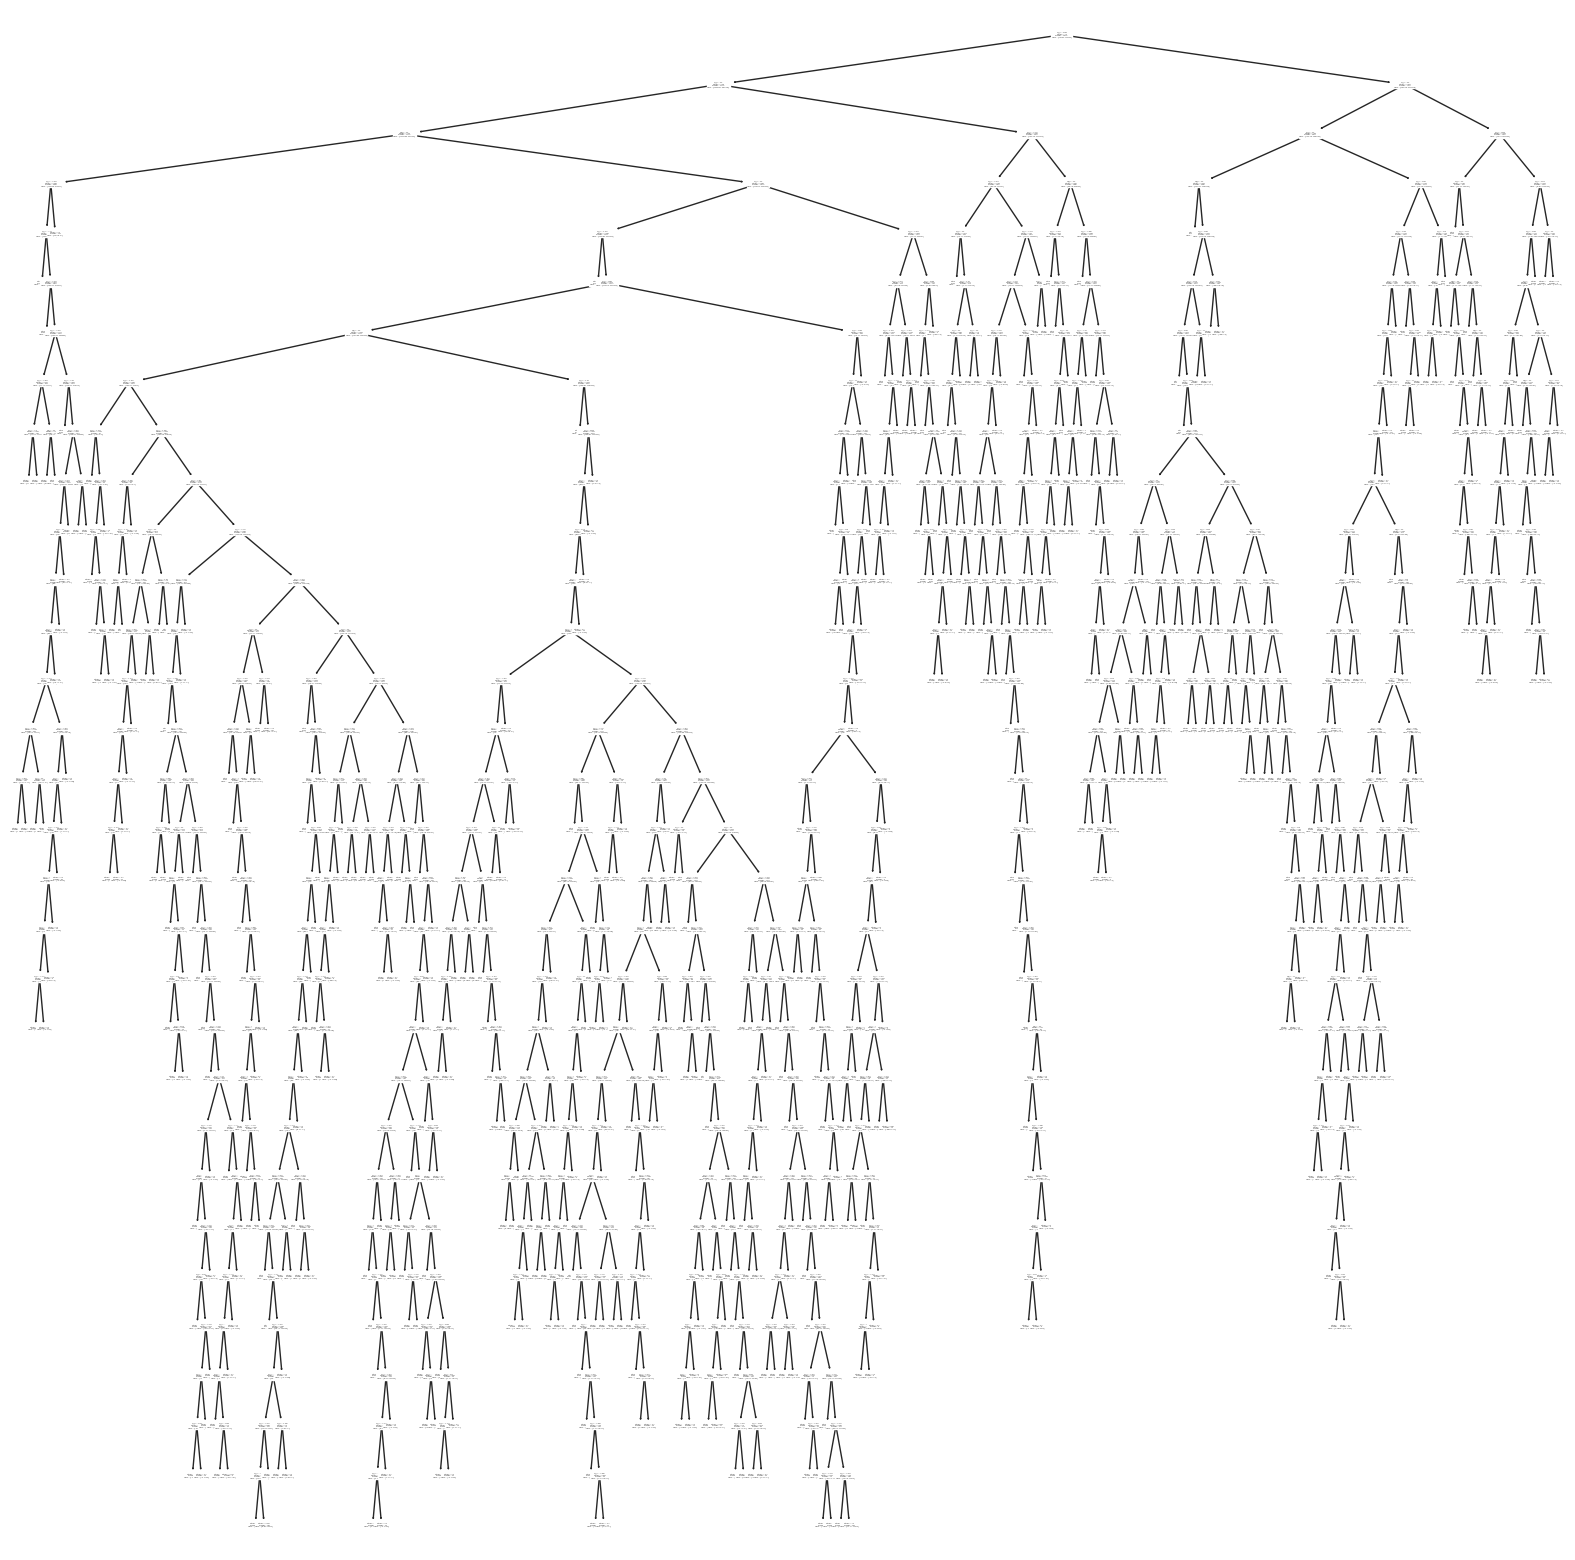

In [ ]:
plt.figure(figsize=(20, 20))
SKTree.plot_tree(tree);
plt.show

#### Random Forest ####

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Grid de hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [5, 10, 20, 30, 40, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

# Grid Search com validação cruzada
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # ou 'roc_auc' se quiser lidar melhor com desbalanceamento
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Avaliar
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Melhores parâmetros encontrados:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Relatório de classificação no conjunto de teste:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      6110
           1       0.92      0.97      0.94      6163

    accuracy                           0.94     12273
   macro avg       0.94      0.94      0.94     12273
weighted avg       0.94      0.94      0.94     12273



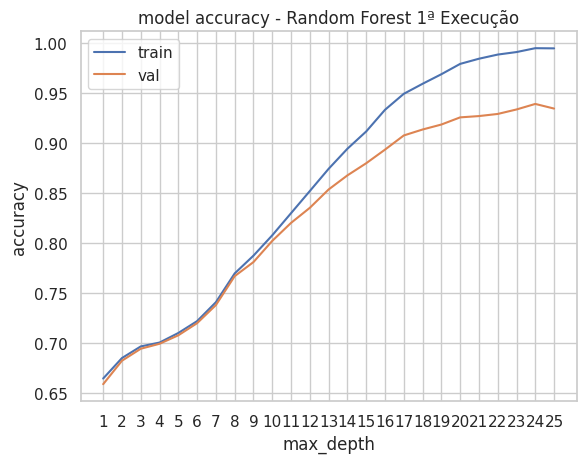

In [ ]:
history_acc_train = []
history_acc_test = []


for max_depth in range(1, 26):
    clf = RandomForestClassifier(
        class_weight='balanced',
        criterion='gini',
        max_depth=max_depth,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=5,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(x_treino, y_treino)

    acc_train = accuracy_score(y_treino, clf.predict(x_treino))
    acc_test = accuracy_score(y_teste, clf.predict(x_teste))

    history_acc_train.append(acc_train)
    history_acc_test.append(acc_test)

plt.plot(range(1, 26),history_acc_train)
plt.plot(range(1, 26),history_acc_test)
plt.xticks(range(1, 26))
plt.title('model accuracy - Random Forest 1ª Execução')
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Modelo: Random Forest (Iteração 1)
  Accuracy:  0.9072
  Precision: 0.9167
  Recall:    0.8966
  F1 Score:  0.9066
----------------------------------------


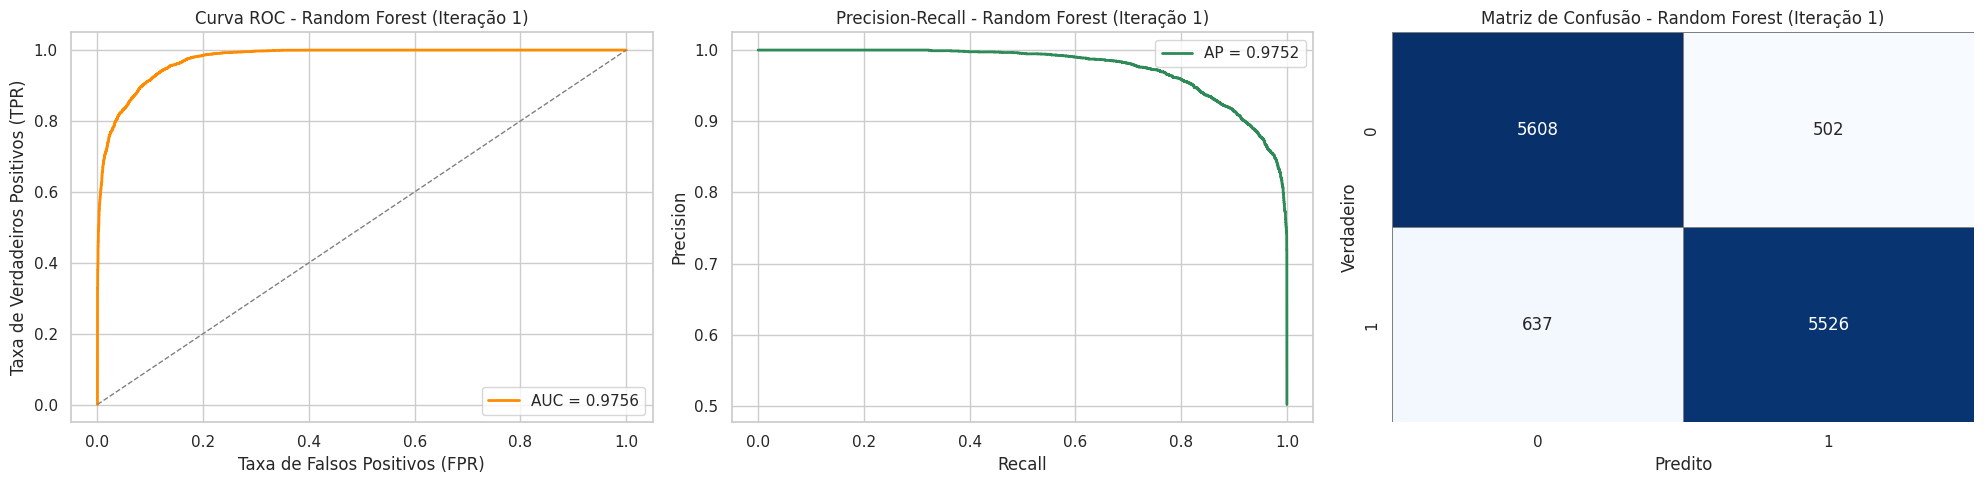

In [ ]:
rfc = RandomForestClassifier(
        class_weight='balanced',
        criterion='gini',
        max_depth=17,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=5,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

rfc.fit(x_treino, y_treino)
y_pred = rfc.predict(x_teste)
y_proba = rfc.predict_proba(x_teste)[:, 1]
metricas('Random Forest', 1, y_teste, y_pred, y_proba)

#### Gradient Booster Classifier ####

In [ ]:
gbc = GradientBoostingClassifier(random_state=42, max_depth=None)

# Grid de hiperparâmetros
param_grid = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt']
}

# Grid Search com validação cruzada
grid = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # ou 'roc_auc', 'recall'
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Avaliar
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

In [ ]:
history_acc_train = []
history_acc_test = []

for max_depth in range(1, 21):
    gbc = GradientBoostingClassifier(
        n_estimators=40,
        learning_rate=0.1,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=5,
        subsample=0.6,
        max_depth=max_depth,
        random_state=42
    )

    gbc.fit(x_treino, y_treino)

    acc_train = accuracy_score(y_treino, gbc.predict(x_treino))
    acc_test = accuracy_score(y_teste, gbc.predict(x_teste))

    history_acc_train.append(acc_train)
    history_acc_test.append(acc_test)


plt.plot(range(1, 21),history_acc_train)
plt.plot(range(1, 21),history_acc_test)
plt.xticks(range(1, 21))
plt.title('model accuracy - Gradient Boosting')
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
gbc = GradientBoostingClassifier(
        n_estimators=40,
        learning_rate=0.1,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=5,
        subsample=0.6,
        max_depth=11,
        random_state=42
    )
gbc.fit(x_treino, y_treino)
y_pred = gbc.predict(x_teste)
y_proba = gbc.predict_proba(x_teste)[:, 1]
metricas('Gradient Boosting', 1, y_teste, y_pred, y_proba)

#### Naive bayes ####

In [ ]:
nbg = SKNB.GaussianNB()

nbg.fit(x_treino, y_treino)
y_pred = nbg.predict(x_teste)
y_proba = nbg.predict_proba(x_teste)[:, 1]
metricas('Naive Bayes - Gaussian', 1, y_teste, y_pred, y_proba)

In [ ]:
nbb = SKNB.BernoulliNB()

nbb.fit(x_treino, y_treino)
y_pred = nbb.predict(x_teste)
y_proba = nbb.predict_proba(x_teste)[:, 1]
metricas('Naive Bayes - Bernoulli', 1, y_teste, y_pred, y_proba)

In [ ]:
nvm = SKNB.MultinomialNB()

ds2 = ds_final[['age', 'heart_disease', 'avg_glucose_level', 'hypertension', 'sex_Female', 'sex_Male', 'smoking_status_Smokes', 'smoking_status_Never_smoked', 'ever_married', 'stroke']]
ds2 = shuffle(ds2, random_state = 42)
sel = ds2.columns.to_list()
sel.remove('stroke')

X1 = ds2[sel]
Y1 = ds2['stroke']

x_treino1, x_teste1, y_treino1, y_teste1 = train_test_split(X1, Y1, test_size=0.3, random_state=42)

nvm.fit(x_treino1, y_treino1)
y_pred = nvm.predict(x_teste1)
y_proba = nvm.predict_proba(x_teste1)[:, 1]
metricas('Naive Bayes - Multinomial', 1, y_teste, y_pred, y_proba)

#### Regressão Logistica ####

In [ ]:
def criar_modelo(optimizer='adam', learning_rate=0.001):
    modelo = Sequential()
    modelo.add(Dense(1, input_dim=x_treino.shape[1], activation='sigmoid'))

    opt = None
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return modelo

# Wrapper para usar no scikit-learn
modelo = KerasClassifier(build_fn=criar_modelo, verbose=0)

# Grid de hiperparâmetros
param_grid = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.01, 0.001]
}

# GridSearchCV
grid = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    verbose=1
)

# Treinamento
grid.fit(x_treino, y_treino)

# Avaliação
print("Melhores hiperparâmetros:")
print(grid.best_params_)

y_pred = (grid.predict(x_teste) > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(1, input_dim=x_treino.shape[1], activation='sigmoid'))

    # Otimização de hiperparâmetros
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [0.01, 0.001])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Aqui adicionamos o Recall como métrica!
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

# Configurando o tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_recall',  # agora o modelo realmente calcula isso
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='logistic_regression_tuning'
)

# Rodando a busca
tuner.search(
    x_treino, y_treino,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Pegando o melhor modelo e hiperparâmetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Melhores hiperparâmetros:")
print("Optimizer:", best_hp.get('optimizer'))
print("Learning rate:", best_hp.get('learning_rate'))

# Avaliação
y_pred_prob = best_model.predict(x_teste)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))

In [ ]:
rl = Sequential([
    Input(shape=(x_treino.shape[1],)),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])
rl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision',  'recall'])
history1 = rl.fit(x_treino, y_treino, epochs=5, batch_size=8, validation_data=(x_teste, y_teste), verbose=0)

In [ ]:
plot_loss(history1, title='Regressão Logística LOSS - 1ª Execução')
plot_acc(history1, title='Regressão Logística ACCURACY - 1ª Execução')
plot_precision(history1, title='Regressão Logística PRECISION - 1ª Execução')
plot_recall(history1, title='Regressão Logística RECALL - 1ª Execução')

In [ ]:
y_pred = rl.predict(x_teste)
y_pred = np.round(y_pred).flatten()
y_proba = rl.predict(x_teste)
y_proba = y_proba.flatten()

metricas('Regressão Logística', 1, y_teste, y_pred, y_proba)

### Segunda Iteração ###

#### Preparação dos dados ####

In [ ]:
ds =  ds_final.copy()

continuas = [col for col in ds.columns if ds[col].nunique() > 2]

scaler = StandardScaler()
pca = PCA(n_components=0.95)
ds[continuas] = scaler.fit_transform(ds[continuas])


ds = shuffle(ds, random_state = 42)

sel = ds.columns.to_list()
sel.remove('stroke')

X = ds[sel]
X = pca.fit_transform(X)
Y = ds['stroke']

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size=0.3, random_state=42)

#### KNN ####

In [ ]:
knn = KNeighborsClassifier()

# Grid de hiperparâmetros
param_grid = {
    'n_neighbors': [7],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],  # Mantemos minkowski e variamos p
    'p': [1, 2],               # p=1 (manhattan), p=2 (euclidean)
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# GridSearchCV
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # ou 'roc_auc', 'recall'
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Resultados
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

In [ ]:
inertia = []
k_range = range(1, 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# 4. Plotar o gráfico do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow) para KMeans')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma dos erros quadráticos)')
plt.grid(True)
plt.show()

In [ ]:
knn = KNeighborsClassifier(algorithm='auto', metric= 'minkowski', p=1, weights='distance', n_neighbors=7)
knn.fit(x_treino, y_treino)
y_pred = knn.predict(x_teste)
y_proba = knn.predict_proba(x_teste)[:, 1]
metricas('KNN', 2, y_teste, y_pred, y_proba)

#### Árvore ####

In [ ]:
tree = SKTree.DecisionTreeClassifier(random_state=42)

# Grid de hiperparâmetros
param_grid = {
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

# Grid search com validação cruzada
grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # ou 'roc_auc', se quiser avaliar melhor o desbalanceamento
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Avaliação
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

In [ ]:
history_acc_train = []
history_acc_test = []

for max_depth in range(1,21):
  clf = SKTree.DecisionTreeClassifier(class_weight= 'balanced', criterion='entropy', max_depth=max_depth, max_features=None, min_samples_leaf= 2, min_samples_split= 2, random_state=42)
  clf = clf.fit(x_treino, y_treino)
  history_acc_train.append(accuracy_score(y_treino,  clf.predict(x_treino)))
  history_acc_test.append(accuracy_score(y_teste,  clf.predict(x_teste)))

plt.plot(range(1, 21),history_acc_train)
plt.plot(range(1, 21),history_acc_test)
plt.xticks(range(1, 21))
plt.title('model accuracy - Tree classifier')
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
tree = SKTree.DecisionTreeClassifier(class_weight= 'balanced', criterion='entropy', max_depth=18, max_features=None, min_samples_leaf= 2, min_samples_split= 2, random_state=42)
tree.fit(x_treino, y_treino)
y_pred = tree.predict(x_teste)
y_proba = tree.predict_proba(x_teste)[:, 1]
metricas('Árvore', 2, y_teste, y_pred, y_proba)

In [ ]:
plt.figure(figsize=(20, 20))
SKTree.plot_tree(tree);
plt.show

#### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Grid de hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [5, 10, 20, 30, 40, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

# Grid Search com validação cruzada
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # ou 'roc_auc' se quiser lidar melhor com desbalanceamento
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Avaliar
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

In [ ]:
history_acc_train = []
history_acc_test = []


for max_depth in range(1, 26):
    clf = RandomForestClassifier(
        class_weight=None,
        criterion='entropy',
        max_depth=max_depth,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=75,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(x_treino, y_treino)

    acc_train = accuracy_score(y_treino, clf.predict(x_treino))
    acc_test = accuracy_score(y_teste, clf.predict(x_teste))

    history_acc_train.append(acc_train)
    history_acc_test.append(acc_test)

plt.plot(range(1, 26),history_acc_train)
plt.plot(range(1, 26),history_acc_test)
plt.xticks(range(1, 26))
plt.title('model accuracy - Random Forest 1ª Execução')
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rfc = RandomForestClassifier(
        class_weight=None,
        criterion='gini',
        max_depth=18,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=70,
        random_state=42,
        n_jobs=-1
)
rfc.fit(x_treino, y_treino)
y_pred = rfc.predict(x_teste)
y_proba = rfc.predict_proba(x_teste)[:, 1]
metricas('Random Forest', 2, y_teste, y_pred, y_proba)

#### Gradient Booster Classifier ####

In [ ]:
gbc = GradientBoostingClassifier(random_state=42, max_depth=None)

# Grid de hiperparâmetros
param_grid = {
    'n_estimators': [20, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt']
}

# Grid Search com validação cruzada
grid = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # ou 'roc_auc', 'recall'
    n_jobs=-1,
    verbose=1
)

# Treinar
grid.fit(x_treino, y_treino)

# Avaliar
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

print("\nRelatório de classificação no conjunto de teste:")
y_pred = grid.predict(x_teste)
print(classification_report(y_teste, y_pred))

In [ ]:
history_acc_train = []
history_acc_test = []

for max_depth in range(1, 31):
    gbc = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        subsample=0.6,
        max_depth=max_depth,
        random_state=42
    )

    gbc.fit(x_treino, y_treino)

    acc_train = accuracy_score(y_treino, gbc.predict(x_treino))
    acc_test = accuracy_score(y_teste, gbc.predict(x_teste))

    history_acc_train.append(acc_train)
    history_acc_test.append(acc_test)

plt.figure(figsize=(10, 10))
plt.plot(range(1, 31),history_acc_train)
plt.plot(range(1, 31),history_acc_test)
plt.xticks(range(1, 31))
plt.title('model accuracy - Gradient Boosting 1ª Execução')
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
gbc = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        subsample=0.6,
        max_depth=12,
        random_state=42
    )
gbc.fit(x_treino, y_treino)
y_pred = gbc.predict(x_teste)
y_proba = gbc.predict_proba(x_teste)[:, 1]
metricas('Gradient Boosting', 2, y_teste, y_pred, y_proba)

#### Naive bayes ####

In [ ]:
nbg = SKNB.GaussianNB()

nbg.fit(x_treino, y_treino)
y_pred = nbg.predict(x_teste)
y_proba = nbg.predict_proba(x_teste)[:, 1]
metricas('Naive Bayes - Gaussian', 2, y_teste, y_pred, y_proba)

In [ ]:
nbb = SKNB.BernoulliNB()

nbb.fit(x_treino, y_treino)
y_pred = nbb.predict(x_teste)
y_proba = nbb.predict_proba(x_teste)[:, 1]
metricas('Naive Bayes - Bernoulli', 2, y_teste, y_pred, y_proba)

In [ ]:
nvm = SKNB.MultinomialNB()

ds2 = ds_final.copy()
ds2 = shuffle(ds2, random_state = 42)
sel = ds2.columns.to_list()
sel.remove('stroke')

nmf = NMF(n_components=8, init='random', random_state=42, verbose=0, max_iter=195)

X1 = ds2[sel]
X1 = nmf.fit_transform(X1)
Y1 = ds2['stroke']

x_treino1, x_teste1, y_treino1, y_teste1 = train_test_split(X1, Y1, test_size=0.3, random_state=42)

nvm.fit(x_treino1, y_treino1)
y_pred = nvm.predict(x_teste1)
y_proba = nvm.predict_proba(x_teste1)[:, 1]
metricas('Naive Bayes - Multinomial', 2, y_teste, y_pred, y_proba)

#### Regressão Logistica ####

In [ ]:
def criar_modelo(optimizer='adam', learning_rate=0.001):
    modelo = Sequential()
    modelo.add(Dense(1, input_dim=x_treino.shape[1], activation='sigmoid'))

    opt = None
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return modelo

# Wrapper para usar no scikit-learn
modelo = KerasClassifier(build_fn=criar_modelo, verbose=0)

# Grid de hiperparâmetros
param_grid = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.01, 0.001]
}

# GridSearchCV
grid = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    verbose=1
)

# Treinamento
grid.fit(x_treino, y_treino)

# Avaliação
print("Melhores hiperparâmetros:")
print(grid.best_params_)

y_pred = (grid.predict(x_teste) > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(1, input_dim=x_treino.shape[1], activation='sigmoid'))

    # Otimização de hiperparâmetros
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', [0.01, 0.001])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Aqui adicionamos o Recall como métrica!
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

# Configurando o tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_recall',  # agora o modelo realmente calcula isso
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='logistic_regression_tuning'
)

# Rodando a busca
tuner.search(
    x_treino, y_treino,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Pegando o melhor modelo e hiperparâmetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Melhores hiperparâmetros:")
print("Optimizer:", best_hp.get('optimizer'))
print("Learning rate:", best_hp.get('learning_rate'))

# Avaliação
y_pred_prob = best_model.predict(x_teste)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))

In [ ]:
rl = Sequential([
    Input(shape=(x_treino.shape[1],)),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
rl.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'auc', 'precision',  'recall'])
history1 = rl.fit(x_treino, y_treino, epochs=3, batch_size=8, validation_data=(x_teste, y_teste), verbose=0)

In [ ]:
plot_loss(history1, title='Regressão Logística LOSS - 1ª Execução')
plot_acc(history1, title='Regressão Logística ACCURACY - 1ª Execução')
plot_precision(history1, title='Regressão Logística PRECISION - 1ª Execução')
plot_recall(history1, title='Regressão Logística RECALL - 1ª Execução')
plot_auc(history1, title='Regressão Logística AUC - 1ª Execução')

In [ ]:
y_pred = rl.predict(x_teste)
y_pred = np.round(y_pred).flatten()
y_proba = rl.predict(x_teste)
y_proba = y_proba.flatten()

metricas('Regressão Logística', 2, y_teste, y_pred, y_proba)

## Análise dos resultados ##

In [ ]:
plotar_metricas_evolucao(resultados)

In [ ]:
plot_roc_por_modelo(resultados)

In [ ]:
plot_pr_por_modelo(resultados)

In [ ]:
plot_conf_matrices(resultados)

In [ ]:
plotar_metricas_evolucao(resultados)
plot_roc_por_modelo_individual(resultados, pasta_destino1)
plot_pr_por_modelo_individual(resultados, pasta_destino1)
plot_conf_matrices_individual(resultados, pasta_destino1)